# Import and Define

In [1]:
from plot import *
import numpy as np
import pandas as pd
import polars as pl
from huggingface_hub import hf_hub_download, snapshot_download

from scipy.stats import spearmanr
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)
from tqdm import tqdm

tqdm.pandas()

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
palette = {
    "GPN-Star": "#2773BA",
    "PhyloP": "#9E66BA",
    "PhastCons": "#C4494B",
}

In [3]:
# model groups

gpn_star_models = ["GPN-Star"]

genome_wide_veps = [
    "PhyloP",
    "PhastCons",
]

In [4]:
WORK_DIR = "tmp/"

# WMGP rare vs. common enrichment

In [5]:
snapshot_download(
    repo_id="songlab/wmgp_balanced", local_dir=f"{WORK_DIR}/wmgp", repo_type="dataset"
)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2169.09it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/wmgp'

In [6]:
V_wmgp = pd.read_parquet(f"{WORK_DIR}/wmgp/test.parquet")

all_models = genome_wide_veps + gpn_star_models
for m in all_models:
    V_wmgp[m] = pd.read_parquet(f"{WORK_DIR}/wmgp/predictions/{m}.parquet")

In [7]:
V_wmgp = pl.from_pandas(V_wmgp)  # compute in polars for efficiency
V_wmgp

chrom,pos,ref,alt,AF,consequence,label,PhyloP,PhastCons,GPN-Star
str,i64,str,str,f32,str,bool,f64,f64,f32
"""1""",3050120,"""G""","""A""",0.21,"""intergenic""",false,-0.015,0.018,2.569848
"""1""",3050199,"""T""","""C""",0.985,"""intergenic""",false,-0.467,0.11,2.740601
"""1""",3050263,"""G""","""T""",0.005,"""intergenic""",true,0.099,0.888,0.656316
"""1""",3050355,"""C""","""T""",0.28,"""intergenic""",false,null,null,0.55831
"""1""",3050404,"""G""","""A""",0.005,"""intergenic""",true,null,null,1.640926
…,…,…,…,…,…,…,…,…,…
"""Y""",90855263,"""A""","""G""",0.36,"""non_coding_transcript_exon""",false,2.91,1.0,-4.366385
"""Y""",90855265,"""A""","""G""",0.21,"""non_coding_transcript_exon""",false,1.074,1.0,-5.610187
"""Y""",90855286,"""T""","""C""",0.22,"""non_coding_transcript_exon""",false,-0.666,0.993,0.994787


In [8]:
results_wmgp = []
for c in tqdm(V_wmgp["consequence"].unique().to_list() + ["all"]):
    if c != "all" and (V_wmgp["consequence"] == c).sum() < 500:
        continue
    df_c = V_wmgp.clone() if c == "all" else V_wmgp.filter(pl.col("consequence") == c)
    df_c = df_c.drop_nulls(subset=all_models)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in all_models:
        try:
            if m not in gpn_star_models:
                # Fix: Apply negation to the score column instead of the DataFrame
                selected_df = df_c.select(["label", pl.col(m).alias("score")])
                selected_df = selected_df.with_columns(pl.col("score") * -1)
                odds_ratio = get_odds_ratio(selected_df, [30]).with_columns(
                    Consequence=pl.lit(c),
                    Model=pl.lit(m),
                    n_pos=pl.lit(n_pos),
                    n_neg=pl.lit(n_neg),
                )
                results_wmgp.append(odds_ratio)
            else:
                odds_ratio = get_odds_ratio(
                    df_c.select(["label", pl.col(m).alias("score")]), [30]
                ).with_columns(
                    Consequence=pl.lit(c),
                    Model=pl.lit(m),
                    n_pos=pl.lit(n_pos),
                    n_neg=pl.lit(n_neg),
                )
                results_wmgp.append(odds_ratio)
        except:
            pass

results_wmgp = pl.concat(results_wmgp).to_pandas()
results_wmgp.head()

100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,6.950945,1.184648e-36,missense,PhyloP,58538,57679
1,30,2.795920,0.000000e+00,missense,PhastCons,58538,57679
2,30,37.198739,3.032802e-293,missense,GPN-Star,58538,57679
3,30,6.138249,4.021377e-24,start_or_stop,PhyloP,702,697
4,30,4.350405,9.915820e-18,start_or_stop,PhastCons,702,697


In [9]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_wmgp["Consequence"] = results_wmgp["Consequence"].replace(replacements)

In [10]:
results_wmgp = results_wmgp.sort_values("Odds ratio", ascending=False)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:414: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


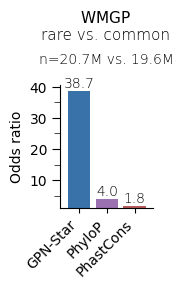

In [11]:
barplot_vertical(
    results_wmgp[(results_wmgp.p_value < 0.05) & (results_wmgp.Consequence == "all")],
    "Odds ratio",
    r"$\bf{\sf{WMGP}}$" + "\nrare vs. common",
    y=1.35,
    width=1.2,
    height=1.6,
    palette=palette,
)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette`

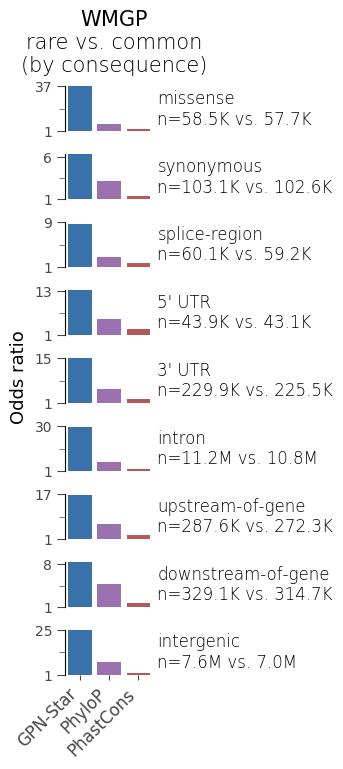

In [12]:
barplot_vertical_aligned(
    results_wmgp[(results_wmgp.n == 30) & (results_wmgp.p_value < 0.05)],
    metric="Odds ratio",
    title=r"$\bf{\sf{WMGP}}$" + "\nrare vs. common\n(by consequence)",
    palette=palette,
    width=1.3,
    height=0.85,
    hspace=0.5,
    suptitle_y=0.98,
    model_order=[
        "GPN-Star",
        "PhyloP",
        "PhastCons",
    ],
    group_order=[
        "missense",
        "synonymous",
        "splice-region",
        "5' UTR",
        "3' UTR",
        "intron",
        "upstream-of-gene",
        "downstream-of-gene",
        "intergenic",
    ],
)

# MMrdb

In [13]:
snapshot_download(
    repo_id="songlab/mmrdb", local_dir=f"{WORK_DIR}/mmrdb", repo_type="dataset"
)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 1303.79it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/mmrdb'

In [14]:
V_mmrdb = pd.read_parquet(f"{WORK_DIR}/mmrdb/test.parquet")

for m in genome_wide_veps + gpn_star_models:
    V_mmrdb[m] = pd.read_parquet(f"{WORK_DIR}/mmrdb/predictions/{m}.parquet")
V_mmrdb

,chrom,pos,ref,alt,label,consequence,pcr_confirmed,PhyloP,PhastCons,GPN-Star
0,16,64586994,A,T,True,stop_gained,True,0.733,1.000,-9.749947
1,8,23603779,G,T,True,splice_acceptor,True,3.040,0.998,-10.276040
2,7,81123210,G,A,True,stop_gained,True,2.562,1.000,-13.029928
3,11,108833460,T,A,True,stop_gained,True,0.200,0.996,-8.458364
4,15,92143687,T,G,True,stop_gained,True,3.716,1.000,-12.370487
...,...,...,...,...,...,...,...,...,...,...
503954,Y,90751450,G,A,False,splice_polypyrimidine_tract,False,NaN,NaN,1.688341
503955,Y,90770787,A,G,False,splice_region,False,1.262,0.999,-0.588489
503956,Y,90796378,G,A,False,splice_donor_5th_base,False,NaN,NaN,0.552545
503957,Y,90796860,C,G,False,splice_region,False,NaN,NaN,0.801525


In [15]:
all_models = genome_wide_veps + gpn_star_models
rows = []
V_mmrdb_c = V_mmrdb.copy()
V_mmrdb_c.dropna(subset=all_models, inplace=True)
V_mmrdb_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_mmrdb_c.label == True).sum(), (V_mmrdb_c.label == False).sum()
pos_prop = n_pos / (n_pos + n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc="models"):
    if m in gpn_star_models:
        AUROC = roc_auc_score(V_mmrdb_c.label == True, -V_mmrdb_c[m])
        AUPRC = average_precision_score(V_mmrdb_c.label == True, -V_mmrdb_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(
            V_mmrdb_c.label == True, -V_mmrdb_c[m]
        )
    else:
        AUROC = roc_auc_score(V_mmrdb_c.label == True, V_mmrdb_c[m])
        AUPRC = average_precision_score(V_mmrdb_c.label == True, V_mmrdb_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(
            V_mmrdb_c.label == True, V_mmrdb_c[m]
        )
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(
    rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"]
)
results = results.sort_values("AUPRC", ascending=False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models:   0%|          | 0/3 [00:00<?, ?it/s]

models: 100%|██████████| 3/3 [09:01<00:00, 180.62s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
2,GPN-Star,0.858588,0.296213,0.010400,0.024030
0,PhyloP,0.769923,0.038125,0.013129,0.006400
1,PhastCons,0.742667,0.003110,0.013254,0.000225


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


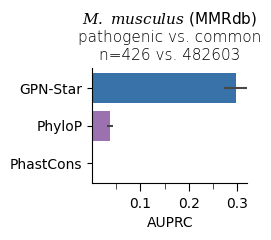

In [16]:
barplot(
    results,
    "AUPRC",
    pos_prop=pos_prop,
    palette=palette,
    figsize=(2, 1.5),
    title=r"$\it{M.\ musculus\ }\bf{\sf{(MMRdb)}}$"
    + f"\npathogenic vs. common\nn={n_pos} vs. {n_neg}",
)